In [2]:
# Author: Yichun Zhao

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import numpy as np
import matplotlib.pyplot as plt


-----------------------DATA PROCESSING-----------------------



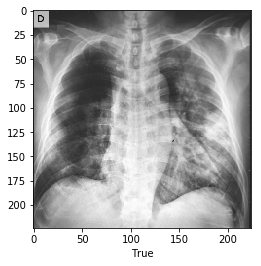

[[212 212 212 ... 166 167 164]
 [180 179 178 ...  65  66  59]
 [179 178 179 ...  65  65  58]
 ...
 [103 102 107 ...  83  65  58]
 [ 98 102 107 ...  83  65  58]
 [ 98 103 109 ...  84  64  58]]


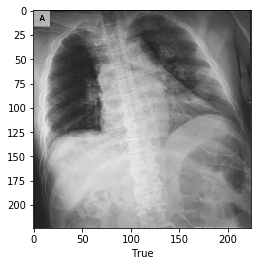

[[254 177 178 ...  73  74  66]
 [254 179 183 ...  79  74  66]
 [255 181 184 ...  92  76  65]
 ...
 [253  57  65 ... 103 103 101]
 [253  57  64 ... 101 104 102]
 [253  57  65 ... 109 102 103]]


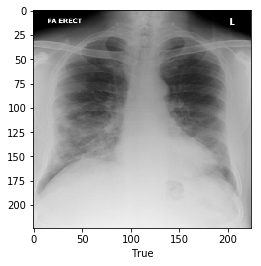

[[  1   0   1 ...   0   0   0]
 [  1   1   1 ...   0   1   0]
 [  0   0   0 ...   0   1   0]
 ...
 [218 219 223 ... 175 163 155]
 [217 219 223 ... 174 164 152]
 [217 217 221 ... 177 168 156]]


In [3]:
# importing data
print("\n-----------------------DATA PROCESSING-----------------------\n")
import os
import imutils
import cv2

images = []
labels = []

yes_path = os.path.abspath('')+"/dataset/train_test/yes/"
for file in os.listdir(yes_path):
    image = cv2.imread(yes_path+file, cv2.IMREAD_GRAYSCALE)
    # resize images to same size
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(True)
    
no_path = os.path.abspath('')+"/dataset/train_test/no/"
for file in os.listdir(no_path):
    image = cv2.imread(no_path+file, cv2.IMREAD_GRAYSCALE)
    # resize images to same size
    image = cv2.resize(image, (224, 224))
    images.append(image)
    labels.append(False)

# visualize input images
import random
for i in random.sample(range(0, 50), 3):
    plt.imshow(images[i], cmap='gray')
    plt.xlabel(labels[i])
    plt.show()
    print(images[i])

# normalize and reshape into appropriate dimensions
images = np.array(images)/255
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) #TF needs 4D shaped data
labels = np.array(labels) * 1
labels = labels.reshape(labels.shape[0], -1) #2D output data

In [7]:
# k fold cross validation
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True)

# build neural net
print("\n-----------------------BUILDING NEURAL NET-----------------------\n")

# build CNN with reference to the AlexNet architecture
# refer to https://www.nature.com/articles/s41598-019-42557-4
model = keras.models.Sequential()
# conv layer 1 with 16 3x3 filters with padding
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# normalize batch after activation to improve computing time
model.add(BatchNormalization())
# max pool 1
model.add(MaxPooling2D((2, 2),strides=2))
# conv layer 2 with 32 3x3 filters
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# normalize batch
model.add(BatchNormalization())
# max pool 2
model.add(MaxPooling2D((2, 2),strides=2))
model.add(Flatten())
# hidden layer
model.add(Dense(128, activation='relu'))
# normalize batch
model.add(BatchNormalization())
# output layer for binary output
model.add(Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n-----------------------TRAINING MODEL-----------------------\n")

fold_num = 1
for train, test in kf.split(images, labels):
    print("Training for fold ", fold_num, "...\n")
    # within each fold, we train and test our network
    
    model.fit(images[train], labels[train], epochs=5, batch_size=9)
    
    test_loss, test_acc = model.evaluate(images[test], labels[test])
    
    print("Accuracy from testing: ", test_acc, "\n")
    
    fold_num = fold_num+1



-----------------------BUILDING NEURAL NET-----------------------


-----------------------TRAINING MODEL-----------------------

Training for fold  1 ...

Epoch 1/5
5/5 [==============================] - 2s 413ms/step - loss: 0.2696 - accuracy: 0.8889
Epoch 2/5
5/5 [==============================] - 2s 463ms/step - loss: 0.0296 - accuracy: 1.0000
Epoch 3/5
5/5 [==============================] - 2s 426ms/step - loss: 0.0702 - accuracy: 0.9778
Epoch 4/5
5/5 [==============================] - 2s 430ms/step - loss: 0.0615 - accuracy: 0.9778
Epoch 5/5
1/1 [==============================] - 0s 1ms/step - loss: 0.9489 - accuracy: 0.4000
Accuracy from testing:  0.4000000059604645 

Training for fold  2 ...

Epoch 1/5
5/5 [==============================] - 2s 466ms/step - loss: 0.0341 - accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 2s 422ms/step - loss: 0.0529 - accuracy: 0.9778
Epoch 3/5
5/5 [==============================] - 2s 422ms/step - loss: 0.0243 - accuracy: 1.000

In [8]:
print("\n-----------------------SUMMARY-----------------------\n")
model.summary()

# model visualization
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')


-----------------------SUMMARY-----------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 16)      160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
________________________________________________________________

In [9]:
# save keras model
model.save(os.path.abspath('')+"/model")

# save to tfjs model for web app
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, os.path.abspath('')+"/webapp/tfjs_model")